# STILL UNDER DEVELOPMENT

In [3]:
import torch
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../')
sys.path.insert(0, '../modules/')
from modules.modules1D_cond_cls_free import Unet1D_cond_cls_free, GaussianDiffusion1D_cond_cls_free

/home/ukb12/miniconda3/envs/ml/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from MITBIH import mitbih_denosing
import random
from torch.utils import data
device = "cuda:3"
ECG_denoising = mitbih_denosing(dataroot = "../heartbeat/", class_id = 0)
dataloader = data.DataLoader(ECG_denoising, batch_size=32, num_workers=4, shuffle=True)
data_dict = next(iter(dataloader))
data_dict['ORG'] = data_dict['ORG'].to(device).to(torch.float)
data_dict['COND'] = data_dict['COND'].to(device).to(torch.float)
data_dict['Labels'] = data_dict['Labels'].to(device).to(torch.long)
data_dict['Index'] = data_dict['Index'].to(device).to(torch.long)

Data shape of Non-Ectopic Beats instances = (72471, 1, 128)


In [6]:

n = 5

model = Unet1D_cond_cls_free(
        dim=64,
        dim_mults=(1, 2, 4, 8),
        num_classes=n,
        cond_drop_prob=0.5,
        self_condition=False,
        in_channels=2,
        out_channels=1
    )
ckpt = torch.load("../checkpoint/DDPM1D_cond_cls_free/checkpoint.pt")
model.load_state_dict(ckpt['model_state_dict'])
model = model.to(device)
diffusion = GaussianDiffusion1D_cond_cls_free(
        model,
        channels=1,
        seq_length=128,
        timesteps=1000,
        conditional=True
    ).to(device)
labels = torch.tensor([0]*5).to(device)
sampled_signals = diffusion.sample(
            x_in=data_dict['COND'][:5],
            classes=labels,
            cond_scale=3.
        )

sampling loop time step: 100%|██████████| 1000/1000 [00:39<00:00, 25.04it/s]


In [7]:
def save_signals_cond_cls_free(sampled_signals, org_signals, cond_signals, labels, **kwargs):
    sampled_signals = sampled_signals.to('cpu').detach().numpy()
    org_signals = org_signals.to('cpu').detach().numpy()
    cond_signals = cond_signals.to('cpu').detach().numpy()
#     print(f'sampled_signals shape is {sampled_signals.shape}') # shape = (5, 1, 128)
#     print(f'org_signals shape is {org_signals.shape}') # shape = (5, 1, 128)
#     print(f'cond_signals shape is {cond_signals.shape}') # shape = (5, 1, 128)
    
    dim = sampled_signals.shape[1]
            
    fig, axs = plt.subplots(3, 5, figsize=(20,5))
    for i in range(5):
        for d in range(dim):
            axs[0, i].plot(org_signals[i][d][:])
            axs[1, i].plot(cond_signals[i][d][:])
            axs[2, i].plot(sampled_signals[i][d][:])
            axs[0, i].set_title(f'{labels[i]}')

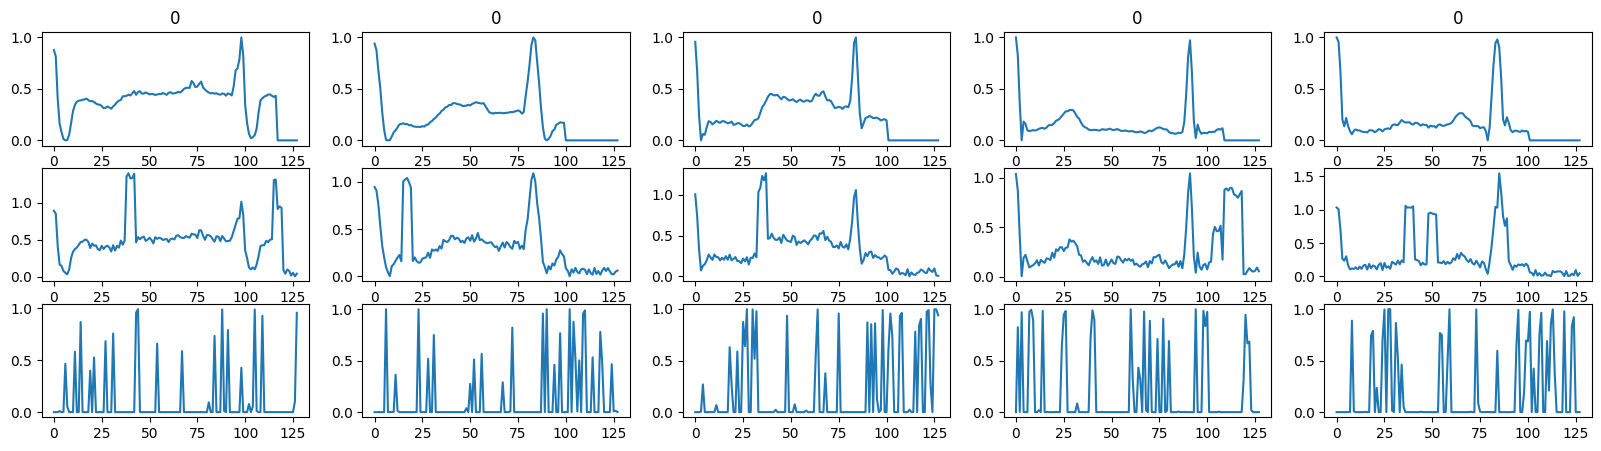

In [9]:
save_signals_cond_cls_free(
            sampled_signals,
            data_dict['ORG'][:5],
            data_dict['COND'][:5],
            labels,
        )